In [1]:
import os
os.chdir('K:/who/sars')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import re
from scipy.optimize import curve_fit

In [3]:
#gompertz curve equation
def gompertz(t,a,b,c):
    return a*np.exp(-1*b*np.exp(-1*c*t))

#using mle to estimate
def get_gompertz_params(x,y):
    popt,pcov=curve_fit(gompertz,x,y,p0=(max(y),1,1))
    return popt

In [4]:
#visualize gompertz curve
def gompertz_viz(df,col,country,save=False,train_pct=[0.3,0.4,0.5,0.75,0.9]):    
        
    data=df[[col,'report date']][df['Country']==country].dropna()

    data.set_index('report date',inplace=True
                   )

    data.index=pd.to_datetime(data.index)
    
    #get actual time difference as the publish frequency isnt consistent
    dif=pd.Series(data.index).diff()

    data['time']=dif.fillna('0').apply(lambda x: re.findall('\d+',str(x))[0]).astype(int).cumsum().tolist()
    
    #viz
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(f'{country}')
    plt.xlabel(f"Time\nwhere t0 is {str(data.index[0])[:10]}")
    plt.ylabel(col)
    
    #using different percentage of training data to do cross validation
    for pct in train_pct:
        
        #using mle to estimate gompertz model
        try:
            a,b,c=get_gompertz_params(data['time'].iloc[:int(len(data)*pct)],
                                      data[col].iloc[:int(len(data)*pct)])

            #start from 3 months ago to a year later
            infected=[gompertz(t,a,b,c) for t in range(-100,400)]
            
            #remove outlier from the figure
            if max(infected)>2*max(data[col]) or int(max(infected))==0:
                continue

            plt.plot(range(-100,400),infected,alpha=0.8,
                     label=f'{round(pct*100,0)}% training data')
            
        except RuntimeError:
            continue
    
    #plot actual curve
    plt.plot(data['time'],data[col],alpha=0.5,
             lw=7,label='actual')    
    plt.legend(loc=2)
    
    if save==True:
        plt.savefig(f'{country}-{col}.png')
        
    plt.show()

In [5]:
df=pd.read_csv('grand.csv')

In [6]:
#due to the data quality issue
#we exclude china to examine the global impact
total=df[['Cumulative number of cases',
          'Number of deaths','report date']][df['Country']=='Total'].dropna()
china=df[['Cumulative number of cases',
          'Number of deaths','report date']][df['Country']=='China'].dropna()

merger=total.merge(china,on='report date',how='outer')

merger['Cumulative number of cases']=merger['Cumulative number of cases_x'].fillna(0)-merger['Cumulative number of cases_y'].fillna(0)
merger['Number of deaths']=merger['Number of deaths_x'].fillna(0)-merger['Number of deaths_y'].fillna(0)

merger=merger[['Cumulative number of cases','Number of deaths','report date']]

merger['Country']='Exclude China'

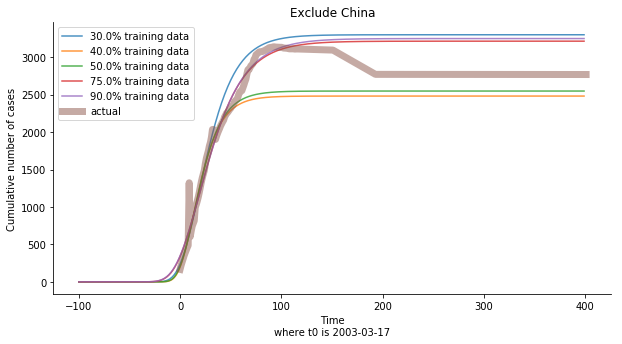

In [7]:
gompertz_viz(merger,'Cumulative number of cases','Exclude China')

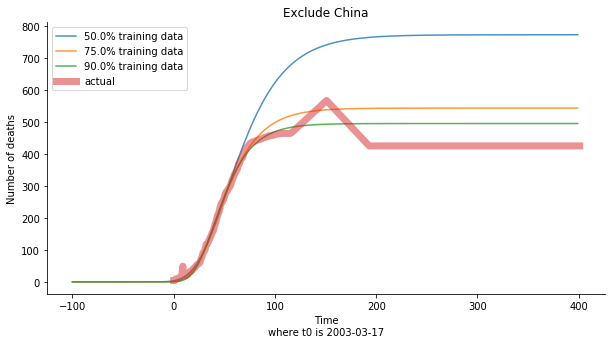

In [8]:
gompertz_viz(merger,'Number of deaths','Exclude China')

In [9]:
#some of the data are very messy
#you see cumulative number go up and down like a rollercoaster
#possibly some of them were false positive but WHO didnt revise the old number
cols=['Number of deaths','Cumulative number of cases']
countries=['Hong Kong','Singapore','Canada','Thailand',
           'Australia','France','Germany','Philippines',
           'Taiwan','United States','China','Total']

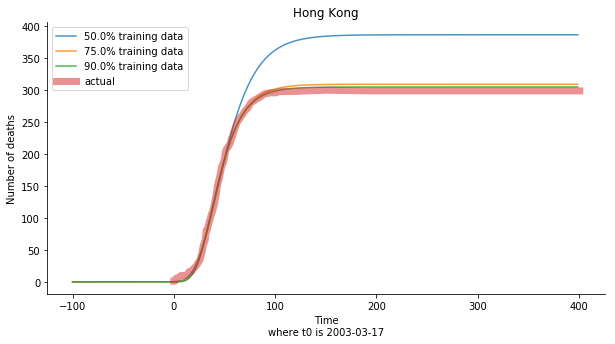

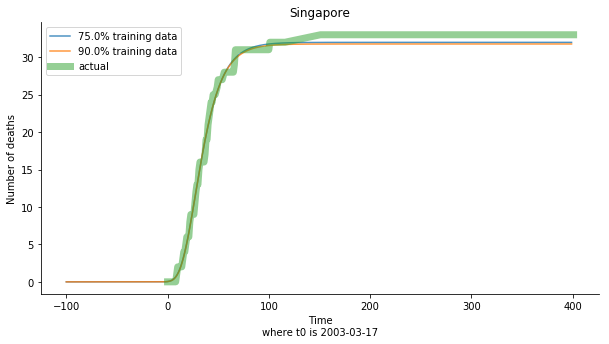

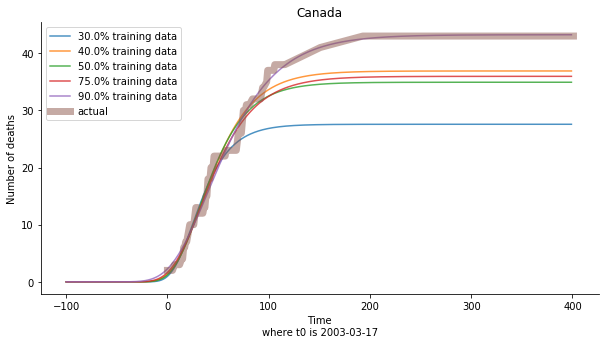

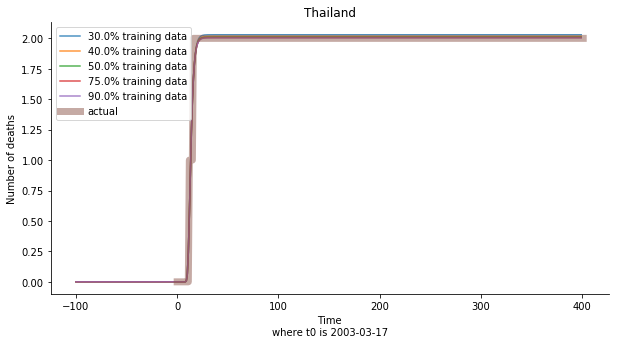

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


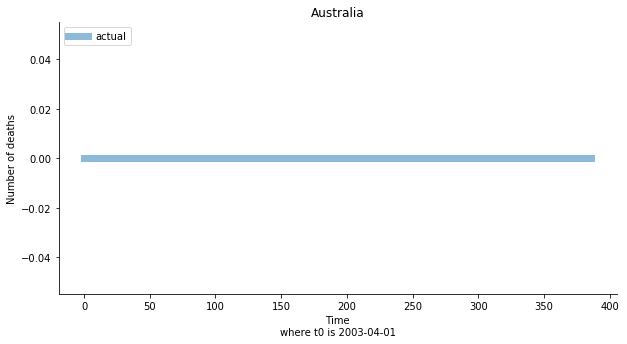

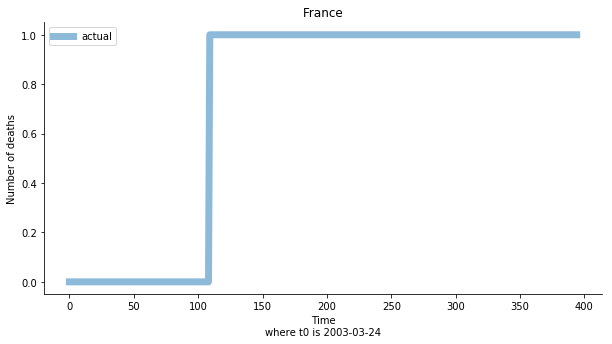

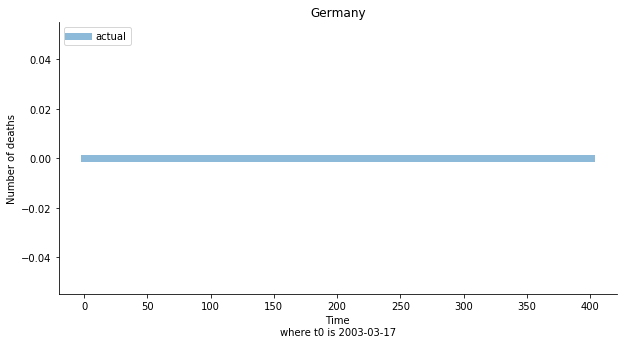

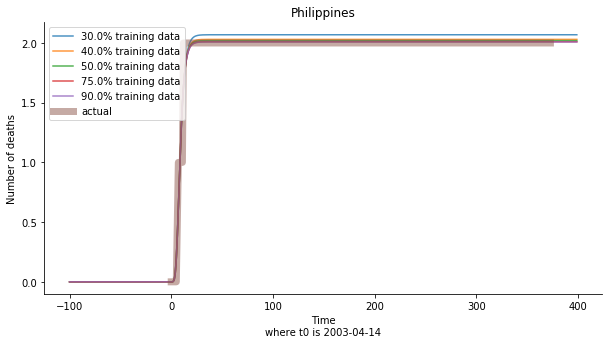

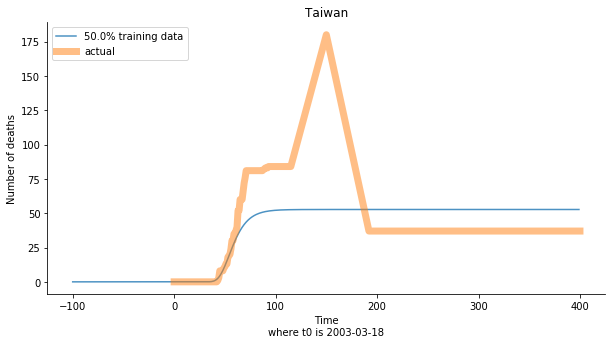

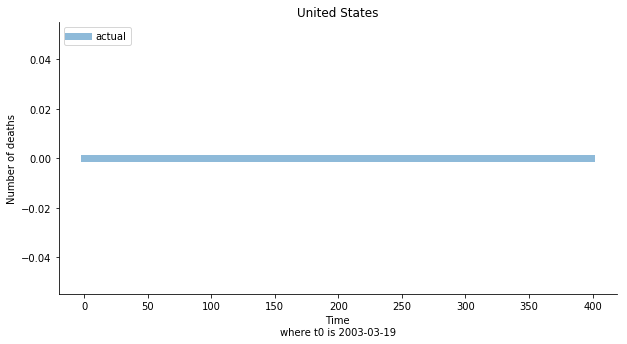

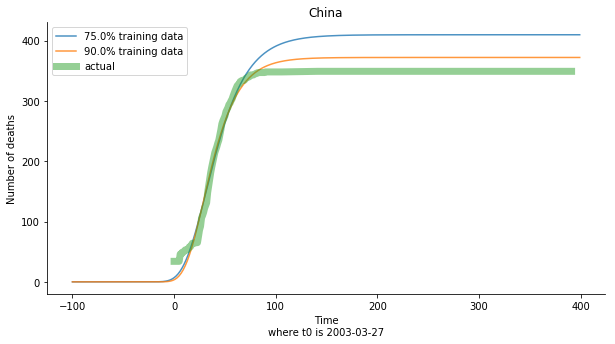

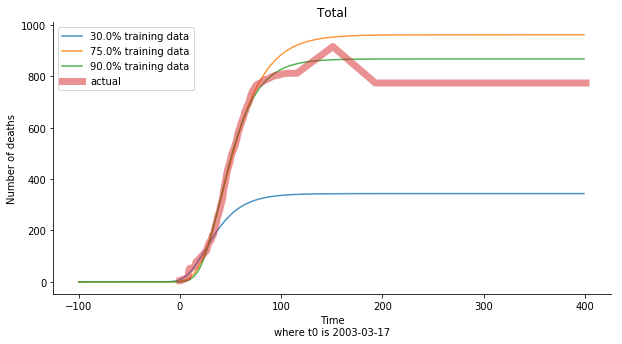

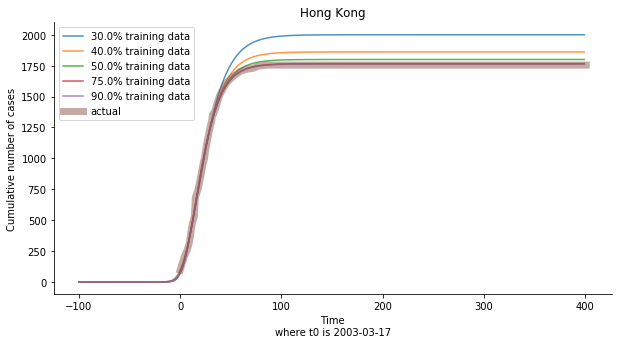

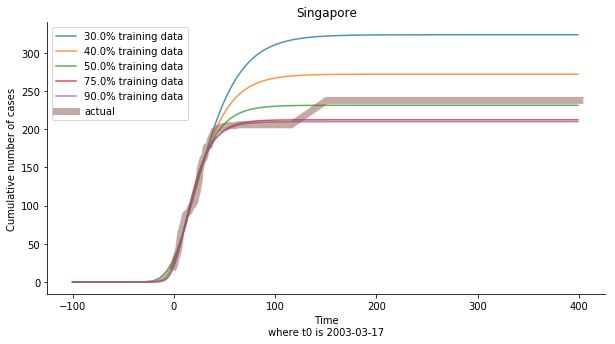

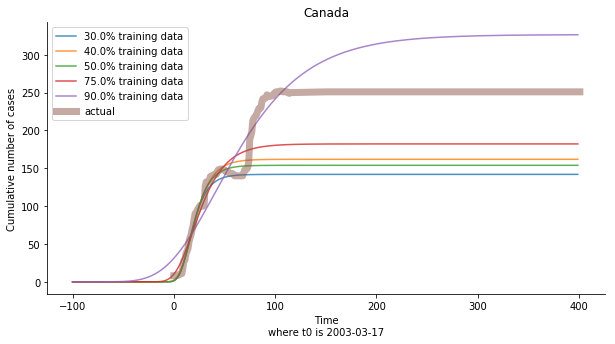

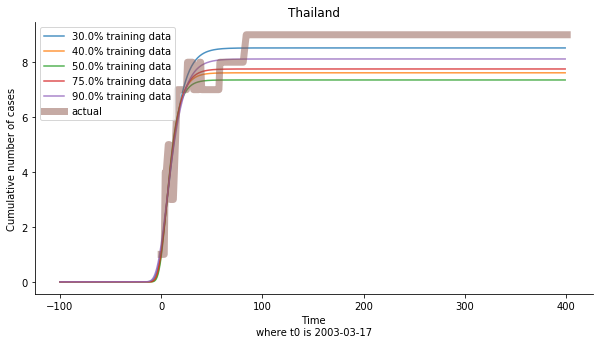

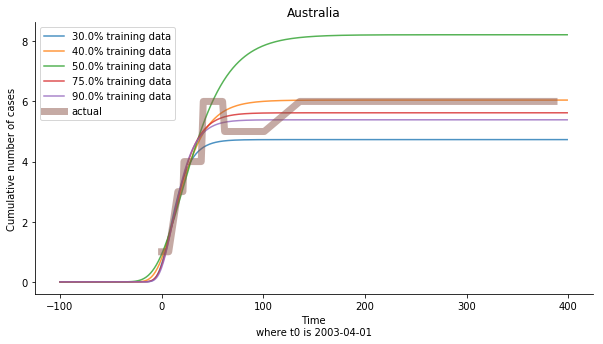

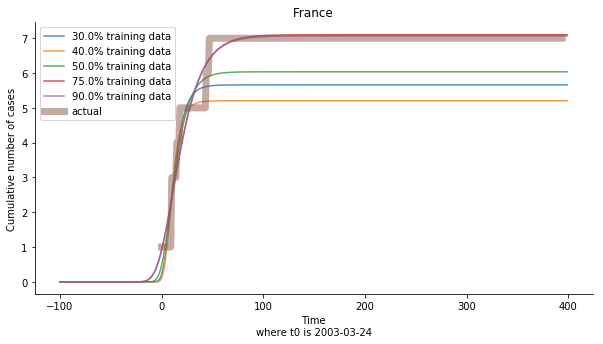

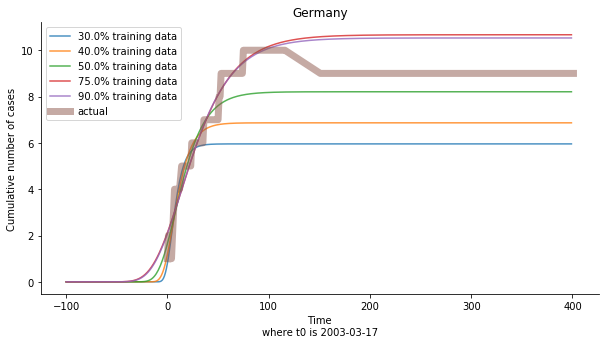

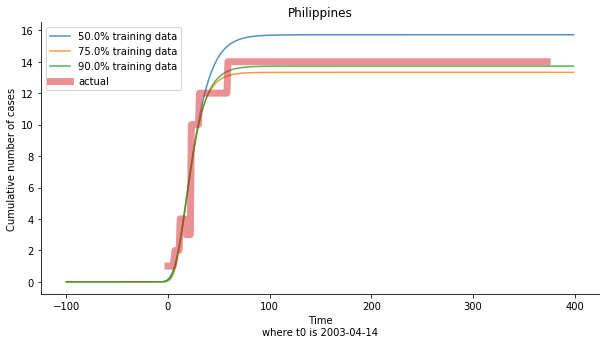

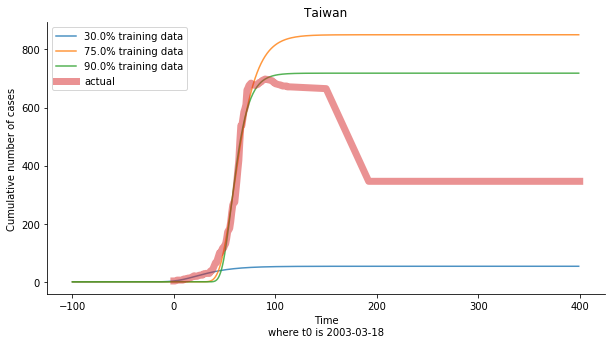

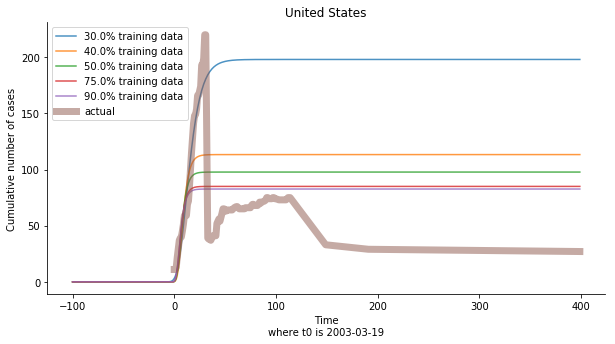

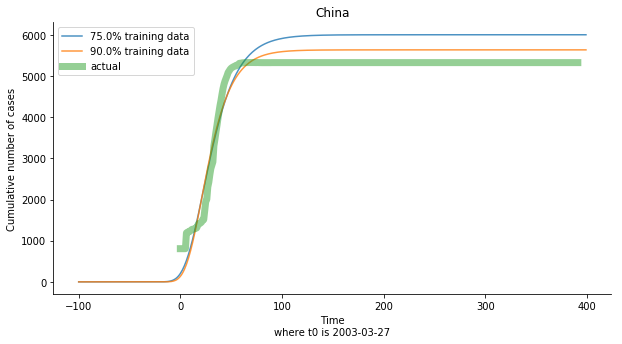

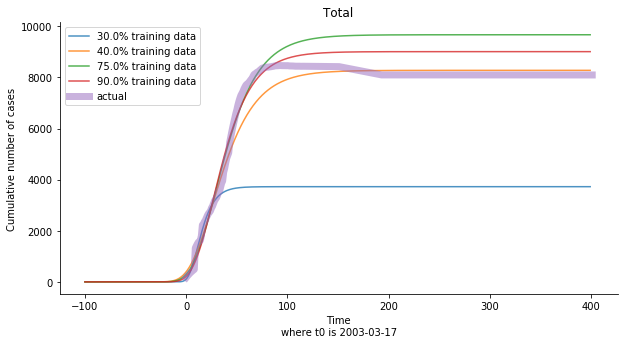

In [10]:
for col in cols:
    for country in countries:
        gompertz_viz(df,col,country)